In [1]:
import sys
import os

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as st


%matplotlib inline

In [2]:
path_data = os.path.join("data", "processed_2_small.csv")

In [4]:
df = pd.read_csv(path_data, sep=";")

In [5]:
df.dtypes

BETRIEBSTAG            object
FAHRT_BEZEICHNER       object
BETREIBER_ID           object
VERKEHRSMITTEL_TEXT    object
BPUIC                   int64
ANKUNFTSZEIT           object
AN_PROGNOSE            object
ABFAHRTSZEIT           object
AB_PROGNOSE            object
dtype: object

In [8]:
dateparser_ddmmyyy = '%d.%m.%Y'
dateparser_ddmmyyHHMM = '%d.%m.%Y %H:%M'
dateparser_ddmmyyHHMMSS = '%d.%m.%Y %H:%M:%S'

In [9]:
df["BETRIEBSTAG"] = pd.to_datetime(df["BETRIEBSTAG"], format=dateparser_ddmmyyy)
df["ANKUNFTSZEIT"] = pd.to_datetime(df["ANKUNFTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AN_PROGNOSE"] = pd.to_datetime(df["AN_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)
df["ABFAHRTSZEIT"] = pd.to_datetime(df["ABFAHRTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AB_PROGNOSE"] = pd.to_datetime(df["AB_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)

In [10]:
df.dtypes

BETRIEBSTAG            datetime64[ns]
FAHRT_BEZEICHNER               object
BETREIBER_ID                   object
VERKEHRSMITTEL_TEXT            object
BPUIC                           int64
ANKUNFTSZEIT           datetime64[ns]
AN_PROGNOSE            datetime64[ns]
ABFAHRTSZEIT           datetime64[ns]
AB_PROGNOSE            datetime64[ns]
dtype: object

In [11]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT


In [12]:
df["VERSPAETUNG_AN"] = df["AN_PROGNOSE"] - df["ANKUNFTSZEIT"]
df["VERSPAETUNG_AB"] = df["AB_PROGNOSE"] - df["ABFAHRTSZEIT"]

In [13]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT


In [14]:
df_an_versp = df["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)

In [ ]:
df_an_versp.head(15)

In [15]:
len(df_an_versp)

882207

In [16]:
an_range = np.arange(-2, 10, 0.1)

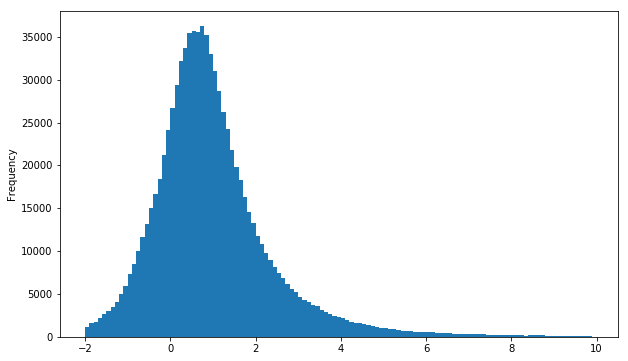

In [17]:
df_an_versp.plot.hist(bins=an_range, figsize=(10, 6))

In [18]:
df_ab_versp = df["VERSPAETUNG_AB"].dropna().apply(lambda d: d.total_seconds() / 60.0)

In [19]:
df_ab_versp.head(15)

1     0.933333
3     0.583333
5     0.466667
7     0.500000
9     0.600000
11    0.633333
13    0.416667
15    0.600000
17    0.466667
19    0.683333
21    0.550000
23    0.483333
25    0.466667
27    0.516667
29    0.333333
Name: VERSPAETUNG_AB, dtype: float64

In [20]:
len(df_ab_versp)

903100

In [21]:
ab_range = np.arange(-2, 10, 0.1)

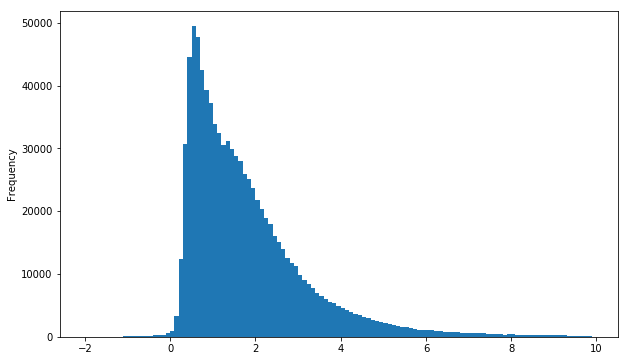

In [22]:
df_ab_versp.plot.hist(bins=ab_range, figsize=(10, 6))

In [23]:
DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
]

In [26]:
y, x = np.histogram(list(df_an_versp), bins=)
for distribution in [st.norm, st.lognorm]:
    print distribution
    try:
        params = distribution.fit(list(df_ab_versp))
        print params
    except Exception as e:
        print e

(1.8730592957590526, 1.9505348885236902)
(0.029979520487039578, -65.99999974593283, 67.8501667811208)


d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
d:\dev\swiss-train-delay-distributions\venv\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Frequency')

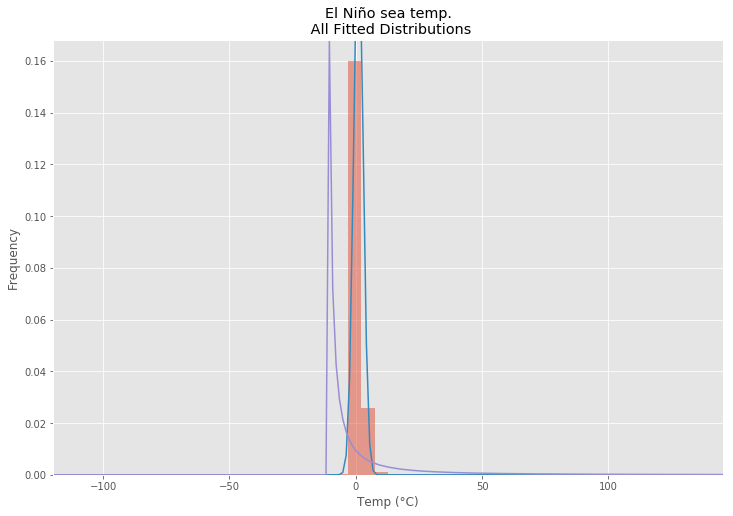

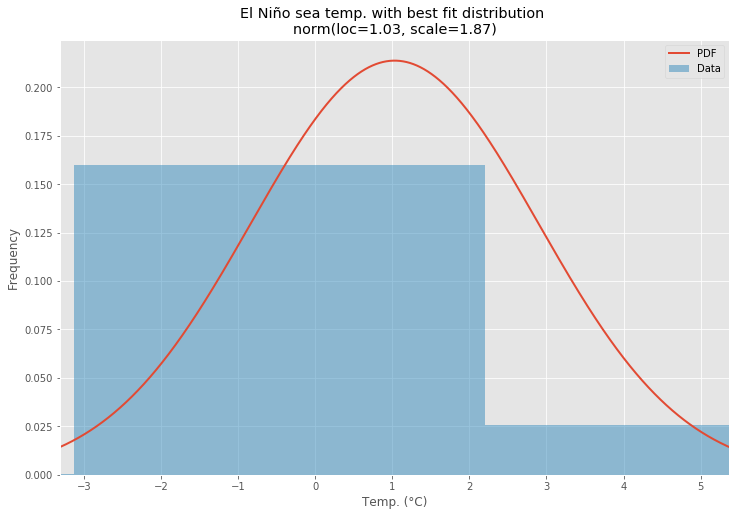

In [30]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=an_range, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
#         st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
#         st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
#         st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
#         st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
#         st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
#         st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
#         st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
#         st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
#         st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
#         st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
        st.norm,
        st.lognorm
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = df_an_versp

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5,
#                color=plt.rcParams['axes.color_cycle'][1]
              )
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')